# NVIDIA NeMo Guardrails

This notebooks demonstrates how to set up and use NVIDIA NeMo's Guardrails. [NVIDIA NeMo](https://www.nvidia.com/en-us/ai-data-science/generative-ai/nemo-framework/) is a cloud-native framework designed for AI models. [NeMo Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) is a toolkit for adding programmable guardrails to LLM-based conversational applications. In this notebook, you will create an RAG-based application featuring Retrieval rails that answer only specific queries regarding the provided knowledge base. 

![Screen Shot 2024-01-23 at 8.37.14 AM.png](<attachment:Screen Shot 2024-01-23 at 8.37.14 AM.png>)
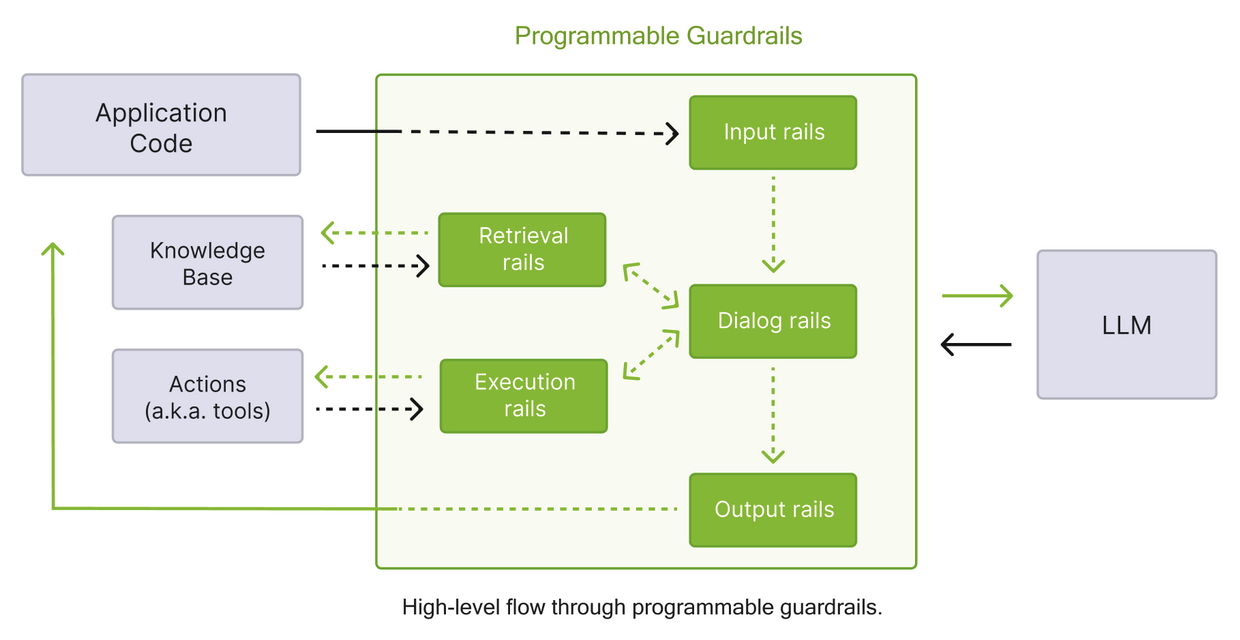

## Prerequisites

You will need a vector-enabled Astra database. This notebook uses OpenAI, though you can certainly use the NVIDIA models, as NeMo [supports all LLM providers supported by Langchain](https://github.com/NVIDIA/NeMo-Guardrails/blob/develop/docs/user_guides/configuration-guide.md#supported-llm-models).

* Create an [Astra vector database](https://docs.datastax.com/en/astra-serverless/docs/getting-started/create-db-choices.html).
* Create an [OpenAI account](https://openai.com/)
* Within your database, create an [Astra DB Access Token](https://docs.datastax.com/en/astra-serverless/docs/manage/org/manage-tokens.html) with Database Administrator permissions.
* Get your Astra DB Endpoint: 
  * `https://<ASTRA_DB_ID>-<ASTRA_DB_REGION>.apps.astra.datastax.com`

See the [Prerequisites](https://docs.datastax.com/en/ragstack/docs/prerequisites.html) page for more details.

## Setup

In [1]:
! pip install -qU ragstack-ai langchain-nvidia-ai-endpoints datasets asyncio nemoguardrails 


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
from getpass import getpass

# Enter your settings for Astra DB and OpenAI:
keys = ["ASTRA_DB_APPLICATION_TOKEN", "ASTRA_DB_API_ENDPOINT", "NVIDIA_API_KEY"]
for key in keys:
    if key not in os.environ:
        os.environ[key] = getpass(f"Enter {key}: ")

In [4]:
# Collections are where documents are stored. ex: test
collection = input("Collection: ")

## Create Guardrails

In [52]:
# The texts are pre-split into portions for ingestion
KNOWLEDGE_BASE = [
"The year 2020 brought unprecedented challenges to the global financial economy, reshaping industries and markets in ways never before seen. From the onset of the COVID-19 pandemic to the profound shifts in consumer behavior, it was a year of resilience, adaptation, and lessons learned. In this blog post, we'll explore key events and statistics that defined the financial landscape of 2020, shedding light on the path forward.",
"The COVID-19 pandemic led to a sharp economic downturn, with global GDP contracting by an estimated 3.5%. Major stock indices experienced historic declines, with the S&P 500 and Dow Jones Industrial Average falling by over 30% in March."
"Governments worldwide responded with unprecedented fiscal and monetary stimulus packages. The total fiscal support provided amounted to over $12 trillion, including direct payments to individuals and loans/grants for businesses. The U.S. government alone passed stimulus packages totaling over $4 trillion, while the Federal Reserve expanded its balance sheet by more than $3 trillion."
"Lockdowns and social distancing measures accelerated existing trends towards e-commerce and remote work. Global e-commerce sales surged by over 30% to $4.28 trillion, while the number of people working remotely doubled to over 40% of the global workforce."
]

In [53]:
from langchain.vectorstores.astradb import AstraDB
from langchain.embeddings import OpenAIEmbeddings

embedding = OpenAIEmbeddings()
vstore = AstraDB(
    collection_name=collection,
    embedding=embedding,
    token=os.getenv("ASTRA_DB_APPLICATION_TOKEN"),
    api_endpoint=os.getenv("ASTRA_DB_API_ENDPOINT"),
)
vstore.add_texts(KNOWLEDGE_BASE)
retriever = vstore.as_retriever()
print("Astra vector store configured")

Astra vector store configured


In [54]:
# Colang is a modeling language enabling the design of guardrails.
# In it, you define user and bot behaviors, as well as the flow of conversations.

COLANG_CONFIG = """
define user ask about economy
    "What was the economy like?"
    "What contributed to the growth or setback of the economy in 2020?"
    "What was the increase in e-commerce sales in 2020?"
    "How much did the S&P 500 fall in 2020?"
    
define flow answer economy question 
    user ...
    $answer = execute rag()
    bot $answer

"""

def yaml_config(engine, model):
    return f"""
    models:
      - type: main
        engine: {engine}
        model: {model}
    """

In [76]:
from langchain.llms.base import BaseLLM
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from nemoguardrails import LLMRails
from nemoguardrails.actions.actions import ActionResult

TEMPLATE = """
Use the following context to answer the question. If you don't know the answer, 
just say that you don't know, do not make up an answer.

Context: {context}

Question: {question}

Answer:
"""

# Define the custom RAG Action
async def rag(context: dict, llm: BaseLLM) -> ActionResult:
    user_message = context.get("last_user_message")
    context_updates = {}

    # Use your pre-defined AstraDB Vector Store as the retriever
    relevant_documents = await retriever.aget_relevant_documents(user_message)
    relevant_chunks = "\n".join([chunk.page_content for chunk in relevant_documents])

    # Use a custom prompt template
    prompt_template = PromptTemplate.from_template(TEMPLATE)
    input_variables = {"question": user_message, "context": relevant_chunks}

    chain = prompt_template | llm | StrOutputParser()
    answer = await chain.ainvoke(input_variables)

    return ActionResult(return_value=answer, context_updates=context_updates)


def init(app: LLMRails):
    app.register_action(rag, "rag")

In [77]:
from nemoguardrails import RailsConfig, LLMRails
from nemoguardrails.integrations.langchain.runnable_rails import RunnableRails

engine = "openai"
model_name = "gpt-3.5-turbo-16k"
yaml = yaml_config(engine, model_name)
config = RailsConfig.from_content(
    colang_content=COLANG_CONFIG,
    yaml_content=yaml,
)

rails = LLMRails(config)
init(rails)

In [78]:
# Your rails is now ready to answer questions about the provided knowledge base 
response = rails.generate(messages=[{
    "role": "user",
    "content": "What was the economy like in 2020?"
}])
print(response["content"])

Error in LoggingCallbackHandler.on_chat_model_start callback: TypeError('can only concatenate list (not "str") to list')


The economy in 2020 experienced a sharp economic downturn due to the COVID-19 pandemic. Global GDP contracted by an estimated 3.5%, and major stock indices such as the S&P 500 and Dow Jones Industrial Average fell by over 30% in March. However, governments worldwide responded with unprecedented fiscal and monetary stimulus packages to mitigate the impact. The total fiscal support provided amounted to over $12 trillion, and the U.S. government alone passed stimulus packages totaling over $4 trillion. Lockdowns and social distancing measures also accelerated trends towards e-commerce and remote work. Global e-commerce sales surged by over 30% to $4.28 trillion, and the number of people working remotely doubled to over 40% of the global workforce.


In [81]:
# Rails does not know about other subjects
response = rails.generate(messages=[{
    "role": "user",
    "content": "What was Michael Jordan's career high score?"
}])
print(response["content"])

Error in LoggingCallbackHandler.on_chat_model_start callback: TypeError('can only concatenate list (not "str") to list')


I'm sorry, I don't have the information to answer that question.
